In [1]:
import itertools
import numpy as np
import torch
import torch.jit
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import sklearn.decomposition
import sklearn.manifold
import sklearn.neighbors
import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
import polars as pl
import scipy.stats
from mpl_toolkits.axes_grid1 import ImageGrid


%matplotlib inline

In [2]:
# sim_dir = "/groups/saalfeld/home/allierc/Py/NeuralGraph/graphs_data/fly/fly_N9_54_1"
# use local copy - faster
sim_dir = "/mnt/localdata/fly_N9_54_1"

In [3]:
x = np.load(f"{sim_dir}/x_list_0.npy")

In [4]:
_, num_cells, _ = x.shape
print(x.shape, x.dtype)

(90720, 13741, 9) float32


In [5]:
neuron_types = x[0, :, 6].astype(np.int32)
index_to_name = {0: 'Am', 1: 'C2', 2: 'C3', 3: 'CT1(Lo1)', 4: 'CT1(M10)', 5: 'L1', 6: 'L2',
    7: 'L3', 8: 'L4', 9: 'L5', 10: 'Lawf1', 11: 'Lawf2', 12: 'Mi1', 13: 'Mi10',
    14: 'Mi11', 15: 'Mi12', 16: 'Mi13', 17: 'Mi14', 18: 'Mi15', 19: 'Mi2',
    20: 'Mi3', 21: 'Mi4', 22: 'Mi9', 23: 'R1', 24: 'R2', 25: 'R3', 26: 'R4',
    27: 'R5', 28: 'R6', 29: 'R7', 30: 'R8', 31: 'T1', 32: 'T2', 33: 'T2a',
    34: 'T3', 35: 'T4a', 36: 'T4b', 37: 'T4c', 38: 'T4d', 39: 'T5a', 40: 'T5b',
    41: 'T5c', 42: 'T5d', 43: 'Tm1', 44: 'Tm16', 45: 'Tm2', 46: 'Tm20', 47: 'Tm28',
    48: 'Tm3', 49: 'Tm30', 50: 'Tm4', 51: 'Tm5Y', 52: 'Tm5a', 53: 'Tm5b',
    54: 'Tm5c', 55: 'Tm9', 56: 'TmY10', 57: 'TmY13', 58: 'TmY14', 59: 'TmY15',
    60: 'TmY18', 61: 'TmY3', 62: 'TmY4', 63: 'TmY5a', 64: 'TmY9'
}
neuron_type_name = [
    "Am", "C2", "C3", "CT1(Lo1)", "CT1(M10)",
    "L1", "L2", "L3", "L4", "L5", "Lawf1", "Lawf2",
    "Mi1", "Mi10", "Mi11", "Mi12", "Mi13", "Mi14", "Mi15", "Mi2", "Mi3", "Mi4", "Mi9",
    "R1", "R2", "R3", "R4", "R5", "R6", "R7", "R8",
    "T1", "T2", "T2a", "T3", "T4a", "T4b", "T4c", "T4d", "T5a", "T5b", "T5c", "T5d",
    "Tm1", "Tm16", "Tm2", "Tm20", "Tm28", "Tm3", "Tm30", "Tm4", "Tm5Y",
    "Tm5a", "Tm5b", "Tm5c", "Tm9", "TmY10", "TmY13", "TmY14",
    "TmY15", "TmY18", "TmY3", "TmY4", "TmY5a", "TmY9"
]
neuron_type_index = {t: i for i, t in enumerate(neuron_type_name)}

def compute_ixs_per_type(neuron_types):
    """Compute indices corresponding to each neuron type."""
    order = np.argsort(neuron_types)
    uniq_types, start_index = np.unique(neuron_types[order], return_index=True)
    num_neuron_types = len(uniq_types)
    assert (uniq_types == np.arange(num_neuron_types)).all(), "breaks assumptions"
    breaks = np.zeros(len(uniq_types)+1, dtype=np.int64)
    breaks[:-1] = start_index
    breaks[-1] = len(neuron_types)
    return [
        order[breaks[i]:breaks[i+1]] for i in range(num_neuron_types)
    ]
neuron_ixs_by_type = compute_ixs_per_type(neuron_types)


In [6]:
BURNIN_OFFSET = 100
OBS_TIME_STEPS = 20

obs_ca = x[BURNIN_OFFSET::OBS_TIME_STEPS, :, 7].copy()
train_start = 0
validation_start = 3000
test_start = 3500

train_mat = obs_ca[train_start:validation_start]
val_mat = obs_ca[validation_start:test_start]

In [7]:
device=torch.device("cuda")
train_tensor = torch.tensor(train_mat, device=device)


In [12]:
class MLP(torch.nn.Module):
    def __init__(
            self,
            num_input_dims: int,
            num_output_dims: int,
            num_hidden_layers: int,
            num_hidden_units: int
        ):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        input_dims = num_input_dims
        for i in range(num_hidden_layers):
            linear = torch.nn.Linear(input_dims, num_hidden_units)
            torch.nn.init.normal_(linear.weight, mean=0., std=0.1)
            torch.nn.init.zeros_(linear.bias)
            self.layers.append(
                linear
            )
            self.layers.append(
                torch.nn.Tanh()
            )
            input_dims = num_hidden_units
        self.layers.append(
            torch.nn.Linear(num_hidden_units, num_output_dims)
        )

    def forward(self, x):
        y = self.layers[0](x)

        for layer in self.layers[1:-1]:
            y = y + layer(y)

        return self.layers[-1](y)

torch.set_float32_matmul_precision('high')
L = 32
encoder = MLP(train_mat.shape[1], L, 3, L).to(device)
decoder = MLP(L, train_mat.shape[1], 3, L).to(device)
evolver = MLP(L, L, 3, L).to(device)

opt = torch.optim.Adam(
    list(itertools.chain(encoder.parameters(), decoder.parameters(), evolver.parameters())),
    lr=1e-3,
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    opt, T_0=1000, T_mult=1, eta_min=1e-5
)
def train(encoder, decoder, evolver, train_tensor):
    opt.zero_grad(True)

    proj = encoder(train_tensor)
    recon = decoder(proj)

    # reconstruction loss
    recon_loss = torch.nn.MSELoss()(train_tensor, recon)

    # Run evolver 7 times
    for _ in range(7):
        proj = proj + evolver(proj)
    recon1 = decoder(proj)

    # time steps are nearby
    nbr_loss = torch.nn.MSELoss()(recon1[:-1], train_tensor[1:])

    loss = nbr_loss + recon_loss
    loss.backward()
    scheduler.step()
    opt.step()
    return loss
train_opt = torch.compile(train, mode="reduce-overhead")
loop = tqdm.trange(100_000, ncols=120)
for i in loop:
    loss = train_opt(encoder, decoder, evolver, train_tensor)
    loop.set_postfix(
        # recon=recon_loss.item(),
        loss=loss.item(),
        lr=f"{scheduler.get_last_lr()[0]:.3e}"
    )

100%|██████████████████████████████████████████████| 100000/100000 [15:55<00:00, 104.62it/s, loss=0.00251, lr=1.000e-03]


In [15]:
loop = tqdm.trange(300_000, ncols=120)
for i in loop:
    loss = train_opt(encoder, decoder, evolver, train_tensor)
    loop.set_postfix(
        # recon=recon_loss.item(),
        loss=loss.item(),
        lr=f"{scheduler.get_last_lr()[0]:.3e}"
    )

100%|██████████████████████████████████████████████| 300000/300000 [47:47<00:00, 104.61it/s, loss=0.00214, lr=1.000e-03]


In [47]:
# just run with slower learning rate
opt = torch.optim.Adam(
    list(itertools.chain(encoder.parameters(), decoder.parameters(), evolver.parameters())),
    lr=1e-5,
)
def train_slow(encoder, decoder, evolver, train_tensor):
    opt.zero_grad(True)

    proj = encoder(train_tensor)
    recon = decoder(proj)

    # reconstruction loss
    recon_loss = torch.nn.MSELoss()(train_tensor, recon)

    # Run evolver 7 times
    for _ in range(7):
        proj = proj + evolver(proj)
    recon1 = decoder(proj)

    # time steps are nearby
    nbr_loss = torch.nn.MSELoss()(recon1[:-1], train_tensor[1:])

    loss = nbr_loss + recon_loss
    loss.backward()
    opt.step()
    return loss
train_slow_opt = torch.compile(train_slow, mode="reduce-overhead")
loop = tqdm.trange(100_000, ncols=120)
for i in loop:
    loss = train_slow_opt(encoder, decoder, evolver, train_tensor)
    loop.set_postfix(
        # recon=recon_loss.item(),
        loss=loss.item(),
        # lr=f"{scheduler.get_last_lr()[0]:.3e}"
    )

100%|████████████████████████████████████████████████████████████| 100000/100000 [15:57<00:00, 104.40it/s, loss=0.00152]


In [105]:
train_tensor.shape

torch.Size([3000, 13741])

In [ ]:
# Save models
# ep = torch.export.export(encoder, (train_tensor,))
# torch.export.save(ep, "/mnt/localdata/encoder.pt2")
# proj = encoder(train_tensor)
# ep = torch.export.export(decoder, (proj,))
# torch.export.save(ep, "/mnt/localdata/decoder.pt2")
# ep = torch.export.export(evolver, (proj,))
# torch.export.save(ep, "/mnt/localdata/evolver.pt2")

In [54]:
val_tensor = torch.tensor(val_mat, device=device)

In [55]:
proj = encoder(val_tensor)
recon = decoder(proj)

proj1 = proj.detach().cpu().numpy()
recon1 = recon.detach().cpu().numpy()

In [67]:
x0 = encoder(val_tensor[:1, :])
results = [x0]
for _ in range((val_tensor.shape[0] - 1)):
    prev = results[-1]
    state = prev.detach().clone()
    for _ in range(7):
        state = state + evolver(state)
    results.append(state)
final = decoder(torch.cat(results, dim=0))
final1 = final.detach().cpu().numpy()

i=6905


(0.0, 10.0)

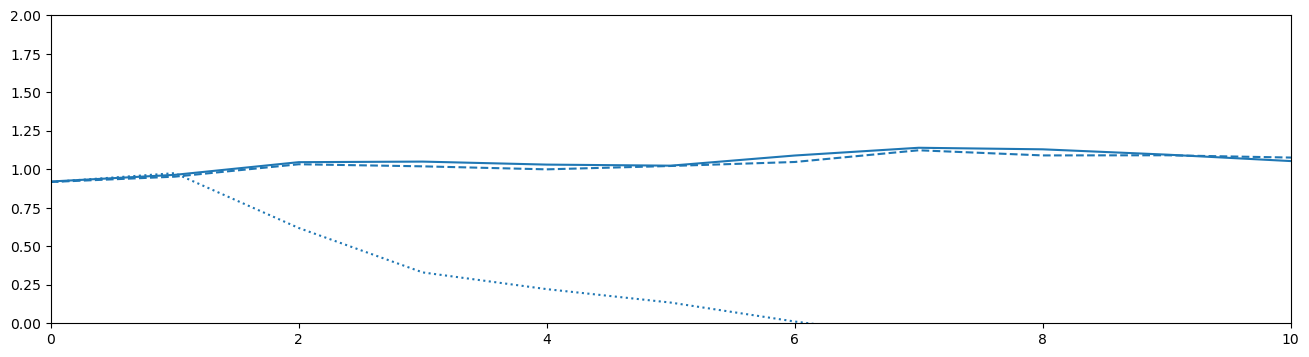

In [102]:
i = np.random.randint(val_mat.shape[1])
print(f"{i=}")
plt.figure(figsize=(16, 4))
p = plt.plot(val_mat[:, i])
plt.plot(final1[:, i], color=p[-1].get_color(), ls="dotted")
plt.plot(recon1[:, i], color=p[-1].get_color(), ls="dashed")
plt.ylim(0, 2)
plt.xlim(0, 10)